In [1]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
import sklearn.svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                    

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


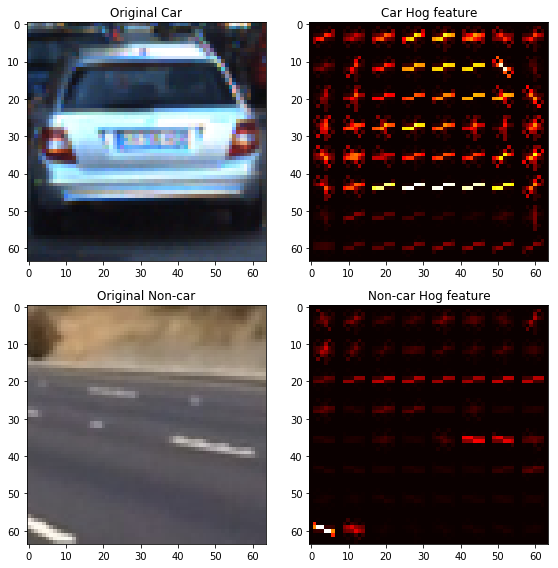

In [77]:
img1 = mpimg.imread('data/val/1/99.png')
img = convert_color(img1)
imgnon1 = mpimg.imread('data/val/0/extra1518.png')
imgnon = convert_color(imgnon1)
orient = 9
pix_per_cell = 8
cell_per_block = 2
(feature, img_out) = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
(featuren, img_outn) = get_hog_features(imgnon[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig = plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(img1)
plt.title('Original Car')
plt.subplot(222)
plt.imshow(img_out, cmap='hot')
plt.title('Car Hog feature')

plt.subplot(223)
plt.imshow(imgnon1)
plt.title('Original Non-car')
plt.subplot(224)
plt.imshow(img_outn, cmap='hot')
plt.title('Non-car Hog feature')

fig.tight_layout()
fig.savefig('hog_example.png')

In [2]:


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    





In [124]:
import sklearn.svm as svm



# Read in cars and notcars
""" 
images = glob.glob('dataset/*.jpeg')
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""

cars = []
notcars = []
images = glob.glob('datasetfull/vehicles/*/*.png')
for image in images:
    cars.append(image)
images = glob.glob('datasetfull/non-vehicles/*/*.png')
for image in images:
    notcars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
 
sample_size = 100
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


print("car size: ", len(cars))
print("non-car size: ", len(notcars))

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))





car size:  100
non-car size:  100
Using: 9 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 1200


In [4]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
parameters = {'kernel':['linear'], 'C':[0.1, 1, 10]}
#svr = svm.SVC()
#svc = GridSearchCV(svr, parameters)
svc = svm.SVC(C=0.1, kernel='linear')
# Use a linear SVC 
#svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

#print("clf.best_params: ", svc.best_params_)

# Check the score of the SVC
from sklearn.externals import joblib
from time import strftime, gmtime 
timenow=strftime("%Y%m%d%H%M%S", gmtime())
print(timenow)
model_name = "model/model-"+timenow+".pk1"
joblib.dump(svc, model_name) 
svc = joblib.load(model_name) 


0.13 Seconds to train SVC...
20180112023149


In [125]:
#model_name="model/model-20180102205747.pk1"
#model_name="model/model-20180103183750.pk1"   # hog with bin, no clor
#model_name="model/model-20180103090809.pk1"
model_name="model/model-20180112193224ycr-16-1-no-color.pk1"
#model_name="model/model-20180112213640ycr-8-2-no-color.pk1"

svc = joblib.load(model_name) 

In [126]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9


In [7]:
print(X_train[0])
print(X_train.shape)

[-0.41059009 -0.43913203 -0.46379541 ..., -0.66387129  0.08890829
  0.87806061]
(800, 1200)


In [118]:
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img



1.2802979946136475 Seconds to train SVC...


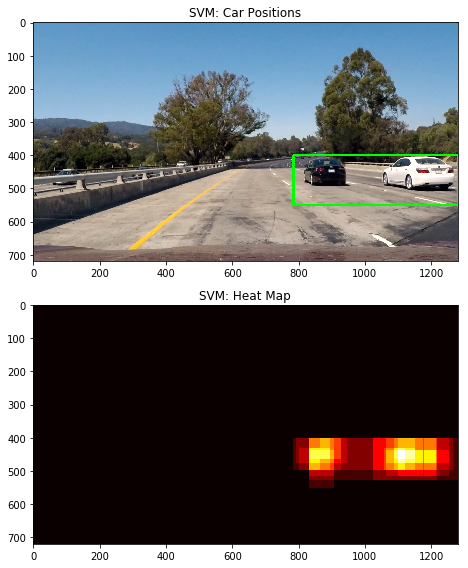

In [199]:


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_half_hog(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    #print(nxsteps, nysteps)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            #print("hog ", hog_features.shape)
            #print("spa ", spatial_features.shape)
            #print("hist ", hist_features.shape)
            
            #all_features = np.hstack((spatial_features, hist_features, hog_features))
            all_features = np.hstack((spatial_features, hog_features))
            #print("all ", all_features.shape, all_features.reshape(1, -1).shape)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(all_features.reshape(1, -1)) 
            #print(max(test_features))
            #print(test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                box = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
                box_list.append(box)
                
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return (draw_img, box_list)
    
xstart = 640
xstop = 1280
ystart = 400
ystop = 656

    
    
#img = mpimg.imread('test_images/bbox-example-image.png')
img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/frame930.jpg')

t=time.time()

heat = np.zeros_like(img[:,:,0]).astype(np.float)

scales = [1, 1.2, 1.5, 2]

for s in scales:
    (out_img, box_list) = find_cars_half_hog(img, xstart, xstop, ystart, ystop, s, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(8,8))
plt.subplot(211)
plt.imshow(draw_img)
plt.title('SVM: Car Positions')
plt.subplot(212)
plt.imshow(heatmap, cmap='hot')
plt.title('SVM: Heat Map')
fig.tight_layout()

fig.savefig("box_example_hog.png")

t2 = time.time()
print(t2-t, 'Seconds to train SVC...')

#plt.imshow(out_img)

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # keep boxes for cars for the last 10 frames
        self.boxes = []


In [23]:
leftLine = Line()
rightLine = Line()

In [211]:
def pipeline_p5_hog(img):
    xstart = 640
    xstop = 1280
    ystart = 400
    ystop = 656

    LABEL_THRESH = 1
    FRAME_NUM = 10
    FRAME_THRESH = 5

    
    scales = [1, 1.2, 1.5, 2]
    # first do heatmap on current frame matches
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for s in scales:
        (out_img, box_list) = find_cars_half_hog(img, xstart, xstop, ystart, ystop, s, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,LABEL_THRESH)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    box_label = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_label.append(bbox)
        
    
    if (len(leftLine.boxes) == FRAME_NUM):
        leftLine.boxes = leftLine.boxes[1:]
    leftLine.boxes.append(box_label) 

    # second do heatmap over frames
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    for b_list in leftLine.boxes:
        heat = add_heat(heat,b_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,FRAME_THRESH)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

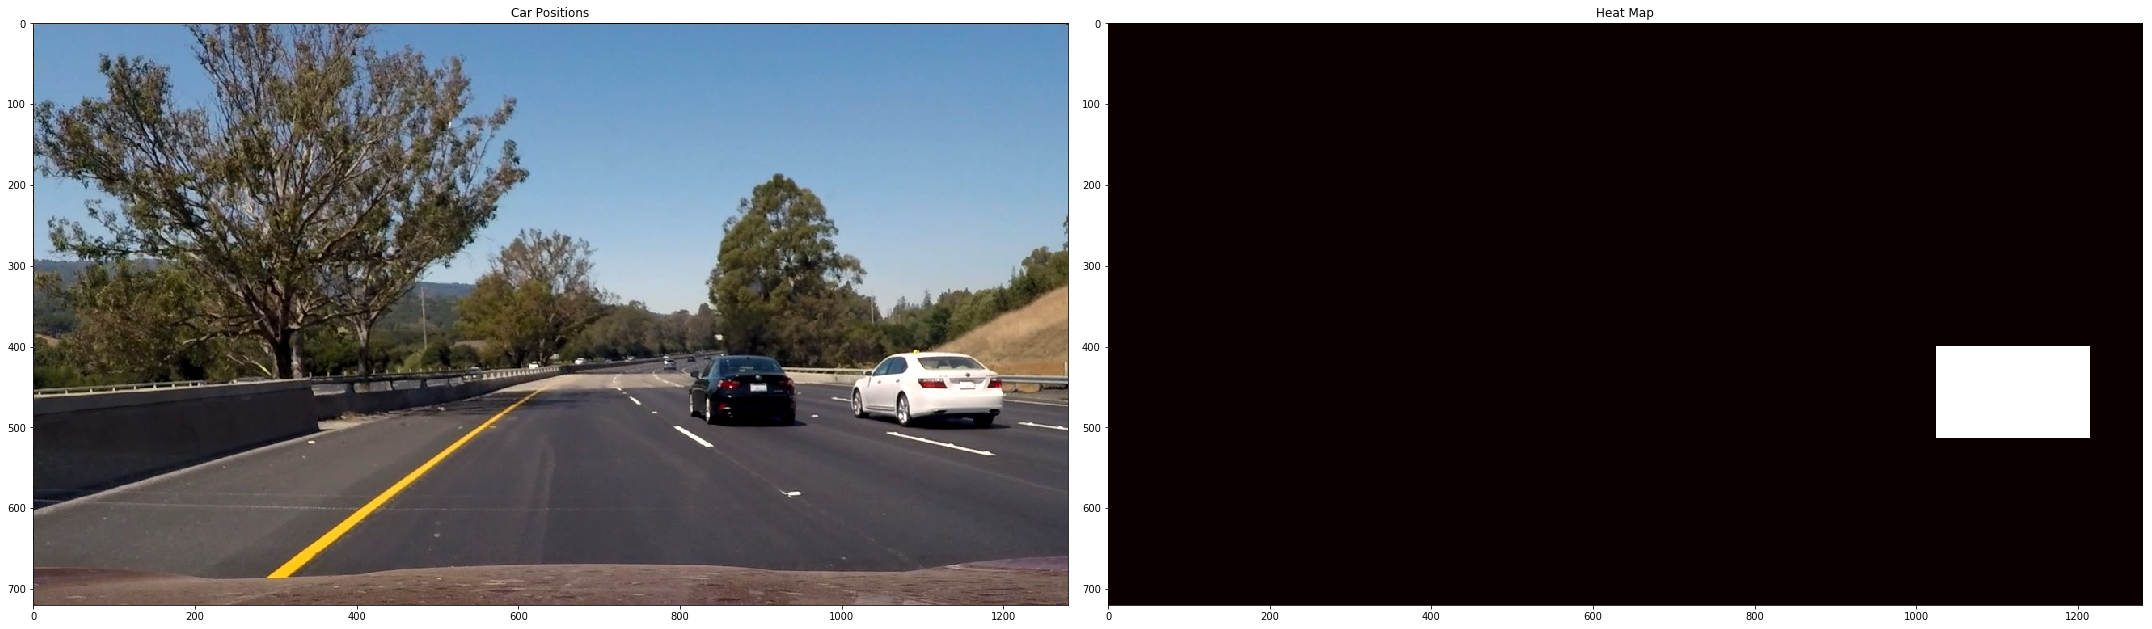

In [212]:
leftLine = Line()
rightLine = Line()

img = mpimg.imread('test_images/test6.jpg')
#img = mpimg.imread('test_images/frame930.jpg')
output = pipeline_p5_hog(img)
fig = plt.figure(figsize=(30,30))
plt.subplot(121)
plt.imshow(output)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [159]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
#%matplotlib

In [160]:
def calibrate():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [161]:
ret, mtx, dist, rvecs, tvecs = calibrate()

In [162]:
# Edit this function to create your own pipeline.
def do_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)    

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    thresh = (10, 130)
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    
    combined = np.zeros_like(s_binary)
    #combined[((sxbinary == 1) | ((s_binary == 1) & (h_binary == 1)))] = 1  
    combined[((sxbinary == 1) | ((s_binary == 1)))] = 1  
    
    return combined

In [163]:
def transform(img):
    # from straight_lines2.jpg   
    src = np.float32([
        [265,683], [1060,683], [738,480], [552, 480]
    ])
    dst = np.float32([
        [300,693], [980,693],[980,350], [300, 350]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return (warped, Minv)

In [164]:
def getLeftRightPoly(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # save left_fit and right_fit to Line objects
    leftLine.allx = leftx
    leftLine.ally = lefty  
    leftLine.current_fit = left_fit
    leftLine.best_fit = left_fit
    
    rightLine.allx = rightx
    rightLine.ally = righty
    rightLine.current_fit = right_fit
    rightLine.best_fit = right_fit
    
    return (ploty, left_fitx, right_fitx)


In [165]:
def getLeftRightPolyUsePrevious(binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # get fit from previous and Fit a second order polynomial to each
    leftx = leftLine.allx 
    lefty = leftLine.ally     
    rightx = rightLine.allx 
    righty = rightLine.ally
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # check if the highest order of fit changes positive <-> negative, if so means bad
    # but if two fit changes together, then still ok
    # if only one changes, then ignore that one
    left_part = 0.2
    right_part = 0.2
    if ((left_fit[0] * leftLine.best_fit[0] > 0) & (right_fit[0] * rightLine.best_fit[0] < 0)):
        # left line ok, right line bad, ignore right_fit, use previous fit
        #print("right fit bad")
        right_part = right_part / 4
    elif ((left_fit[0] * leftLine.best_fit[0] < 0) & (right_fit[0] * rightLine.best_fit[0] > 0)):
        # left line bad, right line ok
        #print("left fit bad")
        left_part = left_part / 4
        
    # try moving average of 5 iterations
    #print("left_fit: ", left_fit, "right: ", right_fit)
    left_fit = left_fit * left_part + leftLine.best_fit * (1 - left_part)
    right_fit = right_fit * right_part + rightLine.best_fit * (1 - right_part)
    #print("avg left_fit: ", left_fit, "right: ", right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # save left_fit and right_fit to Line objects
    leftLine.allx = leftx
    leftLine.ally = lefty  
    leftLine.current_fit = left_fit
    leftLine.best_fit = left_fit
    
    rightLine.allx = rightx
    rightLine.ally = righty
    rightLine.current_fit = right_fit
    rightLine.best_fit = right_fit
    
    return (ploty, left_fitx, right_fitx)

In [166]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def findLane(binary_warped, Minv):
    if (leftLine.allx is None):
        #print("firt fit")
        ploty, left_fitx, right_fitx = getLeftRightPoly(binary_warped) 
    else:
        #print("use previous")
        ploty, left_fitx, right_fitx = getLeftRightPolyUsePrevious(binary_warped)
        #ploty, left_fitx, right_fitx = getLeftRightPoly(binary_warped) 
        
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
    #print("curv", left_curverad, right_curverad)
    # Example values: 1926.74 1908.48 
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    
    left_p = left_fitx[-1]
    right_p = right_fitx[-1]
    mid_p = (left_p + right_p) / 2
    offset = (mid_p - 640) * xm_per_pix
    #print("points ", left_p, right_p)
    
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "curv left: " + str(int(left_curverad)) + ", right: " + str(int(right_curverad))
    cv2.putText(newwarp,text,(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    if (offset > 0):
        text = "offset: " + "{:1.2f} m right of center".format(offset)
    else:
        text = "offset: " + "{:1.2f} m left of center".format(abs(offset))
    cv2.putText(newwarp,text,(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    """ """
    text = "left fit: " + str(leftLine.best_fit) 
    cv2.putText(newwarp,text,(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    text = "right fit: " + str(rightLine.best_fit)
    cv2.putText(newwarp,text,(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    
      
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    """
    
    
    return newwarp
    
    

In [157]:
def pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = do_threshold(undist, s_thresh=(100, 255), sx_thresh=(20, 100))
    warped, Minv = transform(binary)
    newwarp = findLane(warped, Minv)
    p5img = pipeline_p5_hog(undist)
    final = cv2.addWeighted(p5img, 1, newwarp, 0.3, 0)
    return final
    

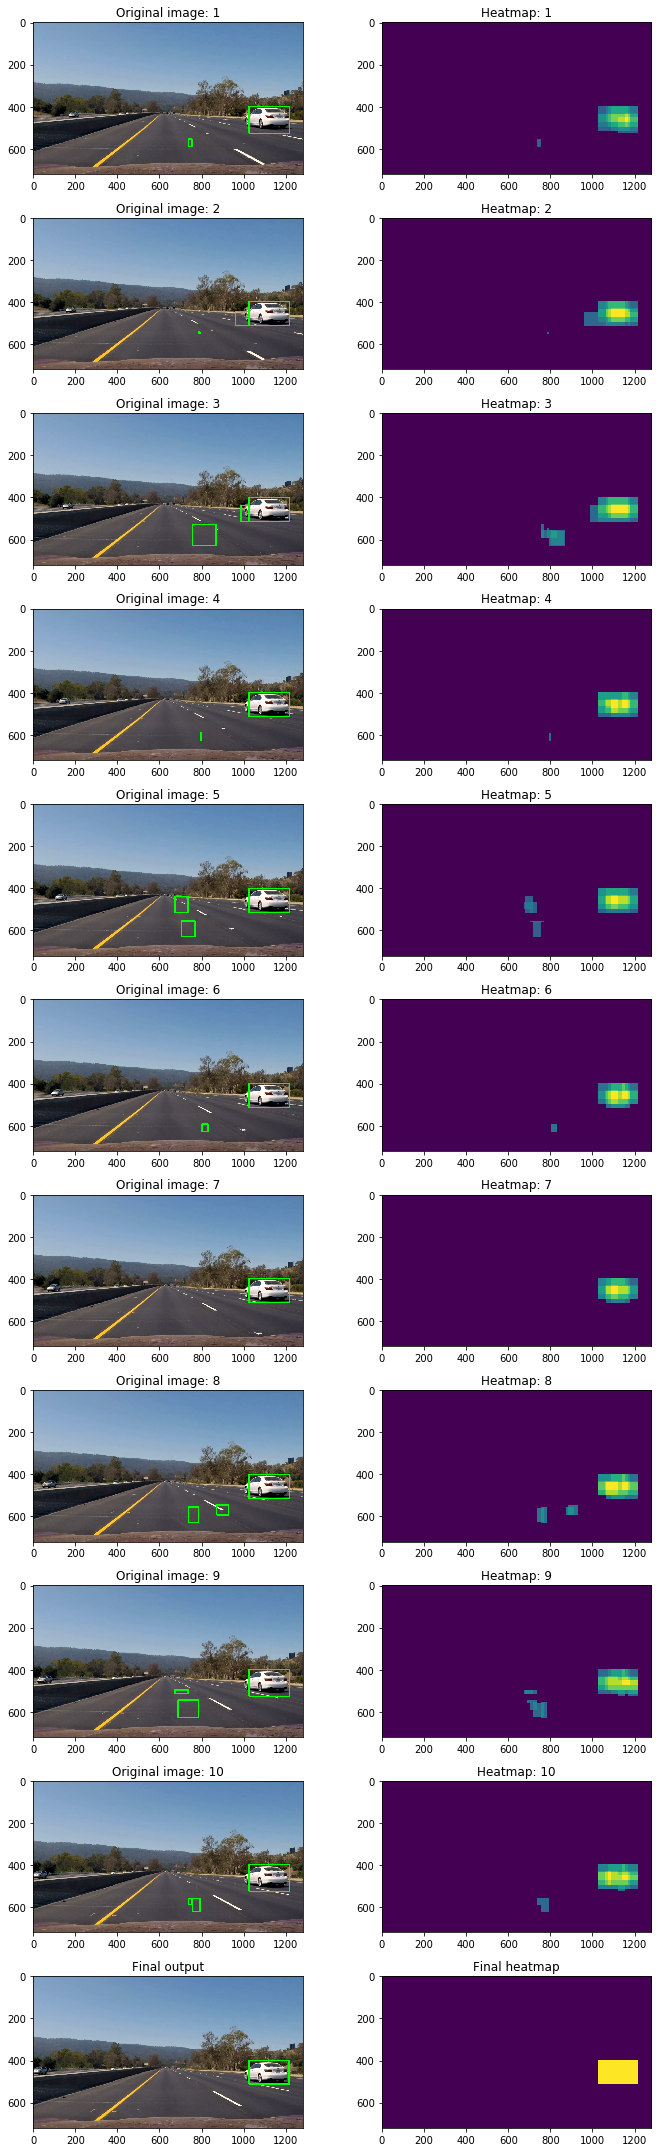

In [204]:
leftLine = Line()
rightLine = Line()

fig = plt.figure(figsize=(10,30))
cnt = 1

xstart = 640
xstop = 1280
ystart = 400
ystop = 656

LABEL_THRESH = 3
FRAME_NUM = 10
FRAME_THRESH = 6


scales = [1, 1.2, 1.5, 2]
all_box = []

for i in range(300, 310):
    img = mpimg.imread('frames/frames/frame'+str(i)+'.jpg') 
    # first do heatmap on current frame matches
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for s in scales:
        (out_img, box_list) = find_cars_half_hog(img, xstart, xstop, ystart, ystop, s, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,LABEL_THRESH)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    box_label = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_label.append(bbox)
    
    all_box.append(box_label)

    plt.subplot(11,2,2*(cnt-1)+1)
    plt.imshow(draw_img)
    plt.title("Original image: " + str(cnt))
    plt.subplot(11,2,2*(cnt-1)+2)
    plt.imshow(heatmap)
    plt.title("Heatmap: " + str(cnt))
    cnt += 1


img = mpimg.imread('frames/frames/frame309.jpg') 
# second do heatmap over frames
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
for b_list in all_box:
    heat = add_heat(heat,b_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,FRAME_THRESH)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
plt.subplot(11,2,21)
plt.imshow(draw_img)
plt.title("Final output")
plt.subplot(11,2,22)
plt.imshow(heatmap)
plt.title("Final heatmap")


fig.tight_layout()
fig.savefig("combine_10_frame.png")



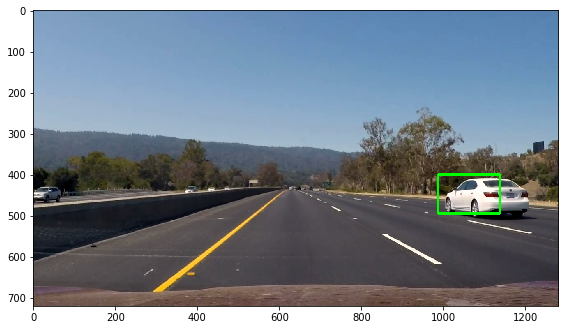

In [191]:
leftLine = Line()
rightLine = Line()
    
fig = plt.figure(figsize=(8,8))
cnt = 1
for i in range(300, 310):   
    image = mpimg.imread('frames/frames/frame'+str(i)+'.jpg')    
    output = pipeline_p5_hog(image)
    cnt += 1

plt.imshow(output)
fig.tight_layout()
fig.savefig("combine_10_frame.png")

In [213]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *

from moviepy.editor import VideoFileClip
from IPython.display import HTML

leftLine = Line()
rightLine = Line()

white_output = 'project_output_hog_16_1_L1_F5.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4").subclip(20,23)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output_hog_16_1_L3_F6.mp4
[MoviePy] Writing video project_output_hog_16_1_L3_F6.mp4


 99%|█████████▊| 75/76 [01:23<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_hog_16_1_L3_F6.mp4 

CPU times: user 1min 23s, sys: 6.45 s, total: 1min 29s
Wall time: 1min 24s


In [214]:
HTML("""
<video width="280" height="270" controls>
  <source src="{0}">
</video>
""".format(white_output))